# Figures 3,4, S1

In [1]:
%load_ext autoreload
%autoreload 2


from pathlib import Path
from cellpose import plot, models, core, utils, io, dynamics, omnipose
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import time, os, sys
from tifffile import imread
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

2021-11-19 15:51:37,353 [INFO] WRITING LOG OUTPUT TO /home/kcutler/.cellpose/run.log
2021-11-19 15:51:41,465 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1


In [2]:
def divergence(mu):
    mask = np.sqrt(np.sum(dP**2,axis=0))
    Ly,Lx = mask.shape
    Y, X = np.nonzero(mask)
    pad = 1
    Tx = np.zeros((Ly+2*pad)*(Lx+2*pad), np.float64)
    Tx[Y*Lx+X] = np.reshape(dP[1].copy(),Ly*Lx)[Y*Lx+X]
    Ty = np.zeros((Ly+2*pad)*(Lx+2*pad), np.float64)
    Ty[Y*Lx+X] = np.reshape(dP[0].copy(),Ly*Lx)[Y*Lx+X]

    div = np.zeros(Ly*Lx, np.float64)
    div[Y*Lx+X]=(Ty[(Y+2)*Lx+X]+8*Ty[(Y+1)*Lx+X]-8*Ty[(Y-1)*Lx+X]-Ty[(Y-2)*Lx+X]+
                 Tx[Y*Lx+X+2]+8*Tx[Y*Lx+X+1]-8*Tx[Y*Lx+X-1]-Tx[Y*Lx+X-2])
    div.shape = (Ly,Lx)
    return div
    
def derivative(T,masks):
    Ly,Lx = T.shape
    mu = np.zeros((2,Ly,Lx))
    pad = 1
    slices = scipy.ndimage.find_objects(masks) 
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            mask = np.pad((masks[sr, sc] == i+1),pad)
            ly, lx = sr.stop - sr.start + 2*pad, sc.stop - sc.start + 2*pad
            y, x = np.nonzero(mask) 
            ly = np.int32(ly)
            lx = np.int32(lx)
            y = y.astype(np.int32)  #no need to shift, as array already padded
            x = x.astype(np.int32)    

            T_ = np.zeros((ly+2*pad)*(lx+2*pad), np.float64)
            T_[y*lx+x] = T[sr.start+y-pad, sc.start+x-pad]
            dy = (T_[(y+1)*lx + x] - T_[(y-1)*lx + x]) / 2
            dx = (T_[y*lx + x+1] - T_[y*lx + x-1]) / 2
            mu[:, sr.start+y-pad, sc.start+x-pad] = np.stack((dy,dx))
    return mu

## Load ground-truth images and labels

In [3]:
train_dir = '/home/kcutler/DataDrive/Omnipose_all/train_sorted'
test_dir = '/home/kcutler/DataDrive/Omnipose_all/test_sorted'
basedir = [train_dir,test_dir]
def get_GT(basedir):
    mask_filter = '_masks'
    img_names = io.get_image_files(basedir,mask_filter,look_one_level_down=True)
    mask_names,flow_names = io.get_label_files(img_names, mask_filter)
    #annoyingly, the names are not sorted properly because the paths are all different for the test folder...
    def getname(path,suffix='_masks'):
        return os.path.splitext(Path(path).name)[0].replace(suffix,'')
    mask_names = sorted(mask_names,key=getname)
    img_names = sorted(img_names,key=getname)
    imgs = [skimage.io.imread(f) for f in img_names]
    # masks_gt = [utils.format_labels(utils.clean_boundary(skimage.io.imread(f))) for f in mask_names]
    masks_gt = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in mask_names]

    return imgs, masks_gt, img_names, mask_names
def f(k):
    if k == 0:
        return 1,2,3,4
    else:
        return 4,3,2,1
imgs =  [[]]*2
masks_gt =  [[]]*2
img_names =  [[]]*2
mask_names =  [[]]*2
for k in range(2):
    imgs[k], masks_gt[k], img_names[k], mask_names[k] = get_GT(basedir[k])
# train_imgs, train_masks, train_img_names, train_mask_names = get_GT(train_dir)
# test_imgs, test_masks, test_img_names, train_mask_names = get_GT(train_dir)

Not all flows are present. Run flow generation again.
Not all flows are present. Run flow generation again.


In [4]:
# count images to verify they are all there 
x = 0
for k in range(2):
    c = len(imgs[k])
    print(c)
    x+=c
x

249
148


397

## Data collection

In [5]:
import scipy.ndimage
from skimage import measure
import edt
import cv2
def getname(path,suffix='.tif'):
        return os.path.splitext(Path(path).name)[0].replace(suffix,'')


pad = 10

bad_cell = [[] for k in range(2)]
good_cell = [[] for k in range(2)]
all_cells = [[] for k in range(2)]
all_regs = [[] for k in range(2)]
d2b = [[] for k in range(2)]
md2b = [[] for k in range(2)]
ang = [[] for k in range(2)]
# good_or_bad =[[] for k in range(2)]
for k in range(2):
    for j,masks in enumerate(masks_gt[k]):
        name = getname(img_names[k][j])
        # Get the dimensions of the mask, preallocate arrays to store flow values
        Ly, Lx = masks.shape
        mu = np.zeros((2, Ly, Lx), np.float64)
        mu_c = np.zeros((Ly, Lx), np.float64)

        regions = measure.regionprops(masks)
        all_regs[k].append(regions)
        for i,rg in enumerate(regions):
            label = rg.label
            bbx = rg.bbox
            y0 = max(0,bbx[0]-pad)
            y1 = min(Ly,bbx[2]+pad)
            x0 = max(0,bbx[1]-pad)
            x1 = min(Lx,bbx[3]+pad)
            labels = masks[y0:y1,x0:x1] 
            mask = labels==label
            if rg.area>5:
                # x, y ordered list of componenets for the mask pixels
                y,x = np.nonzero(mask)
                contours = cv2.findContours((mask>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                x_,y_ = np.concatenate(contours[-2], axis=0).squeeze().T 

                # original boundary projection
                ymed = np.median(y)
                xmed = np.median(x)
                imin = np.argmin((x-xmed)**2 + (y-ymed)**2) 
                xmed_ = x[imin]
                ymed_ = y[imin]

                dist_to_bound = np.sqrt((x_-xmed)**2 + (y_-ymed)**2) #absolute distance to boundary
                imin = np.argmin(dist_to_bound)
                min_dist_to_bound =dist_to_bound[imin]
                l = len(dist_to_bound)
                diff_ind = int(l/2-imin) % l
                
                # roll the minimum to the center
                dist_to_bound = np.roll(dist_to_bound,diff_ind)
                x_ = np.roll(x_,diff_ind)
                y_ = np.roll(y_,diff_ind)
                
                angles = np.array([np.arctan2([y_[i]-ymed],[x_[i]-xmed]) for i in range(len(y_))])
                phase = imgs[k][j][y0:y1,x0:x1]
                
                if np.abs(ymed-ymed_)>.5 or np.abs(xmed-xmed_)>.5:
                    min_dist_to_bound *= -1.
                    bad_cell[k].append([mask,phase,dist_to_bound,angles,ymed,xmed,ymed_,xmed_,y_,x_,name,labels])
                else:
                    good_cell[k].append([mask,phase,dist_to_bound,angles,ymed,xmed,ymed_,xmed_,y_,x_,name,labels])
                    
                all_cells[k].append([mask,phase,dist_to_bound,angles,ymed,xmed,ymed_,xmed_,y_,x_,name,labels])
                
                md2b[k].append(min_dist_to_bound)
                d2b[k].append(dist_to_bound)
                ang[k].append(angles)
            else:
                print('Size error',i,j,k,label)

Size error 27 7 1 28
Size error 28 7 1 29
Size error 30 7 1 31
Size error 35 29 1 36
Size error 395 59 1 396
Size error 490 59 1 491


### Calculate the percentage of projected cells

In [6]:
bad_percent = [[]]*2
good_percent = [[]]*2
for k in range(2):
    nbad = len(bad_cell[k])
    ngood = len(good_cell[k])
    total1 = nbad+ngood
    total2 = len(all_cells[k])
    if total1==total2:
        total=total1
    else:
        print('error',total1,total2)
    bad_percent[k] = nbad/total*100
    good_percent[k] = ngood/total*100
    print('Cell count = %d.'%total, '\nFraction with/without projection:',bad_percent[k],good_percent[k])

Cell count = 27518. 
Fraction with/without projection: 2.2421687622646997 97.7578312377353
Cell count = 19532. 
Fraction with/without projection: 2.902928527544542 97.09707147245545


### Consolidate single-cell data

In [7]:
areas = [[rg.area for region in all_regs[k] for rg in region] for k in range(2)]
diameters = [[utils.diameters(np.pad(rg.image,1),omni=True)[0] for region in all_regs[k] for rg in region] for k in range(2)]
perimeters = [[rg.perimeter for region in all_regs[k] for rg in region] for k in range(2)]

In [8]:
ratio = [[i / j for i, j in zip(md2b[k],diameters[k])] for k in range(2)]
np.median(areas[1])

272.0

### Calculate percentage of cells with 'off center' center

In [9]:
total = len(ratio[0])
new_bad_percent = np.count_nonzero(np.array(ratio[0])<.2)/total*100
diff = new_bad_percent  - bad_percent[0]
print(diff)

8.503524965477144


## Figure S1
Explore cell properties to confirm that test dataset is representative of training dataset

KstestResult(statistic=0.02900689567078296, pvalue=8.754264285077341e-09)
KstestResult(statistic=0.03021295301060567, pvalue=1.703384802631106e-09)
KstestResult(statistic=0.07554172982480051, pvalue=3.8321286528753725e-57)
KstestResult(statistic=0.06559844048066321, pvalue=3.4297025537425187e-43)
KstestResult(statistic=0.06191774819911289, pvalue=1.5948767083152527e-38)


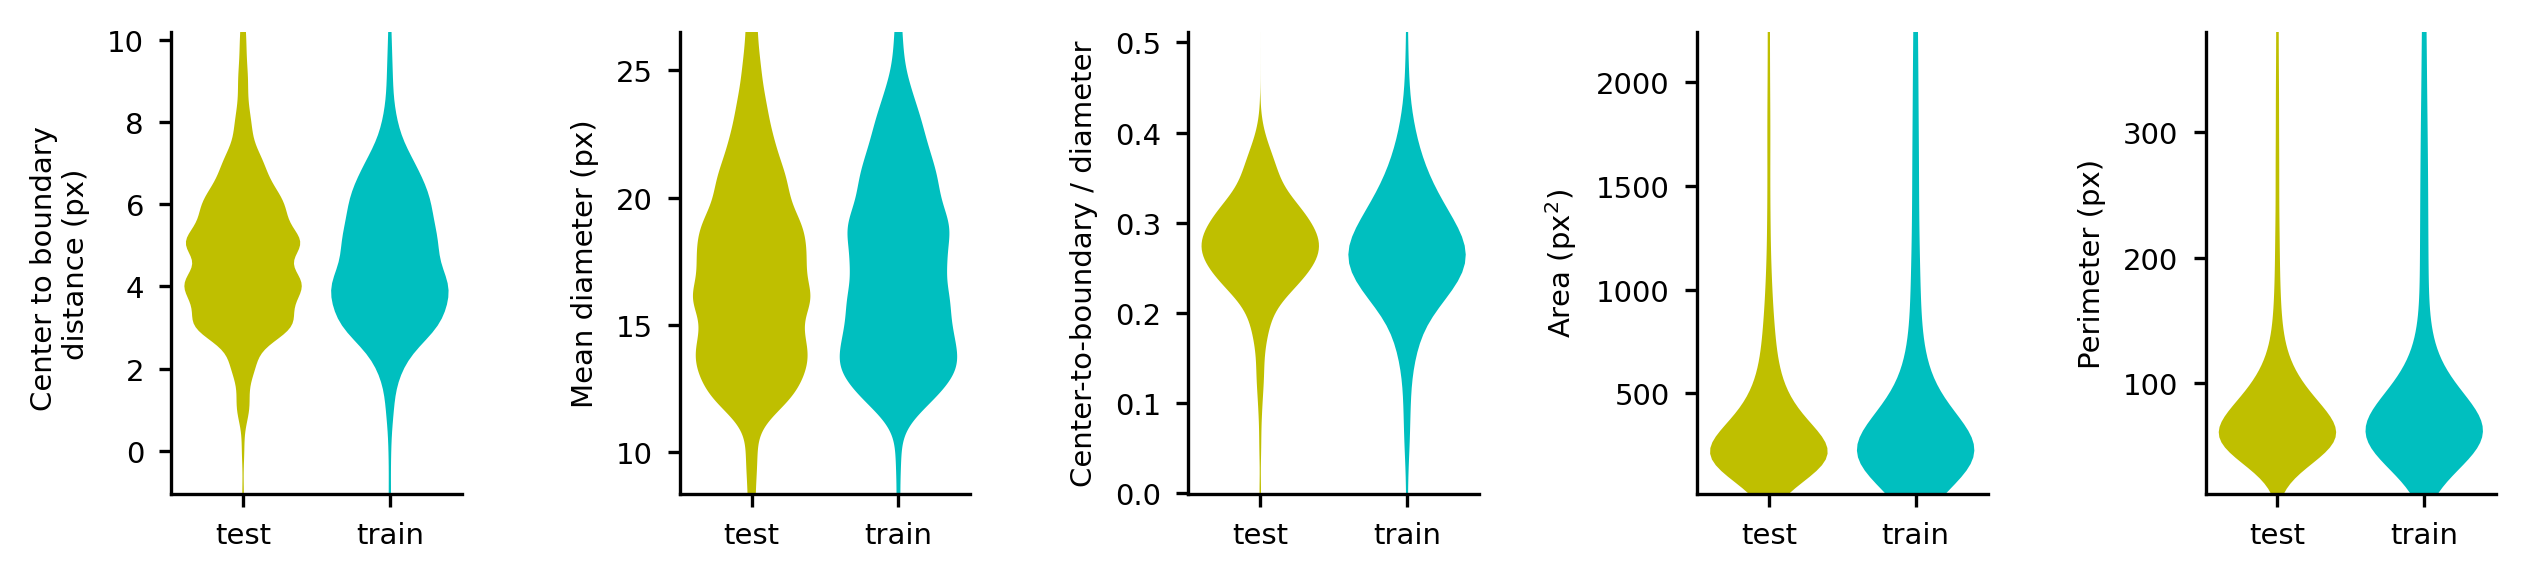

In [10]:
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
%matplotlib inline
darkmode = False
if darkmode:
    plt.style.use('dark_background')
    axcol = 'w'
    colors = sinebow(J+1)
    colors = [colors[j+1] for j in range(n)]
    background_color = 'k'
else:
    mpl.rcParams.update(mpl.rcParamsDefault)
    axcol = 'k'
    cmap = mpl.cm.get_cmap('viridis')
#     colors = cmap(np.linspace(0,.9,len(names)))
#     colors = master_color_scheme
    background_color = np.array([1,1,1,1])
    
mpl.rcParams['figure.dpi'] = 300

golden = (1 + 5 ** 0.5) / 2
sz = 2
labelsize = 7
axcol = 'k'
colors = ['y','c']


labels = ['Center to boundary \ndistance (px)','Mean diameter (px)','Center-to-boundary / diameter','Area (px$^2$)','Perimeter (px)']
data = [md2b,diameters,ratio,areas,perimeters]
J = len(data)

fig,axs = plt.subplots(1,J,figsize=(sz*J,sz))
D = .75
plt.subplots_adjust(wspace=D, hspace = D)
for j in range(J):
# for j in [1,3,4]:
    print(scipy.stats.ks_2samp(data[j][0],data[j][1]))
    ax = axs[j]
    x = [-.25,.25]
    parts = ax.violinplot(data[j],x,showmeans=0, showextrema=0,widths=.4,points=1000)
    for i,pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(1)
    #     pc.set_edgecolor('none')
#         pc.set_edgecolor(colors[i])

    ax.set_xticks(x)
    ax.set_xticklabels(['test','train'])#,rotation = 45)
    ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)

    ax.set_ylabel(labels[j], fontsize = labelsize)
#     if j != 1:
#         ax.set_yscale('log')
#     if j == 3:
#         ax.set_ylim(0,1000)
#     if j == 4:
#         ax.set_ylim(0,1000)
    m = np.mean(data[j][0])
    s = np.std(data[j][0])
    low = max(m-2*s,np.min(data[j][0]))
    high = min(m+2*s,np.max(data[j][0]))
    ax.set_ylim(low,high)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# plt.yscale('log')
plt.show()

In [34]:
# figure out how may cells are in each group
dfggdfgdfdfgfdgfdgdfgdf here

In [11]:
basedir = '/home/kcutler/DataDrive/Omnipose_paper/Figure S1/'
io.check_dir(basedir)
fig.savefig(os.path.join(basedir,'cell_statistics.eps'),bbox_inches=0)

In [22]:
r = ratio[0]
m = np.mean(r)
s = np.std(r)
t = len(r)
np.sum(r<m)/t*100

36.94309179446181

In [23]:
# dists = np.array([np.abs(bad_cell[0][i][2]) for i in range(len(bad_cell[0]))])
# np.argmax(dists)
# len(bad_cell[0])
dists = [np.abs(bad_cell[0][i][2]) for i in range(len(bad_cell[0]))]
angles = [bad_cell[0][i][3] for i in range(len(bad_cell[0]))]

In [24]:
p = 100

th_bad = []
r_bad = []
for i in range(len(bad_cell[0])):
    r = np.abs(bad_cell[0][i][2]).flatten()
    theta = bad_cell[0][i][3].flatten()
#     selection = r<=np.percentile(r,p)
#     select_theta = theta[selection]
    th_bad.append(theta)
    r_bad.append(r)
th_good = []
r_good = []
for i in range(len(good_cell[0])):
    r = np.abs(good_cell[0][i][2]).flatten()
    theta = good_cell[0][i][3].flatten()
#     selection = r<=np.percentile(r,p)
#     select_theta = theta[selection]
    th_good.append(theta)
    r_good.append(r)
th_good = np.array([item for sublist in th_good for item in sublist])
th_bad  = np.array([item for sublist in th_bad for item in sublist])
r_good = np.array([item for sublist in r_good for item in sublist])
r_bad  = np.array([item for sublist in r_bad for item in sublist])


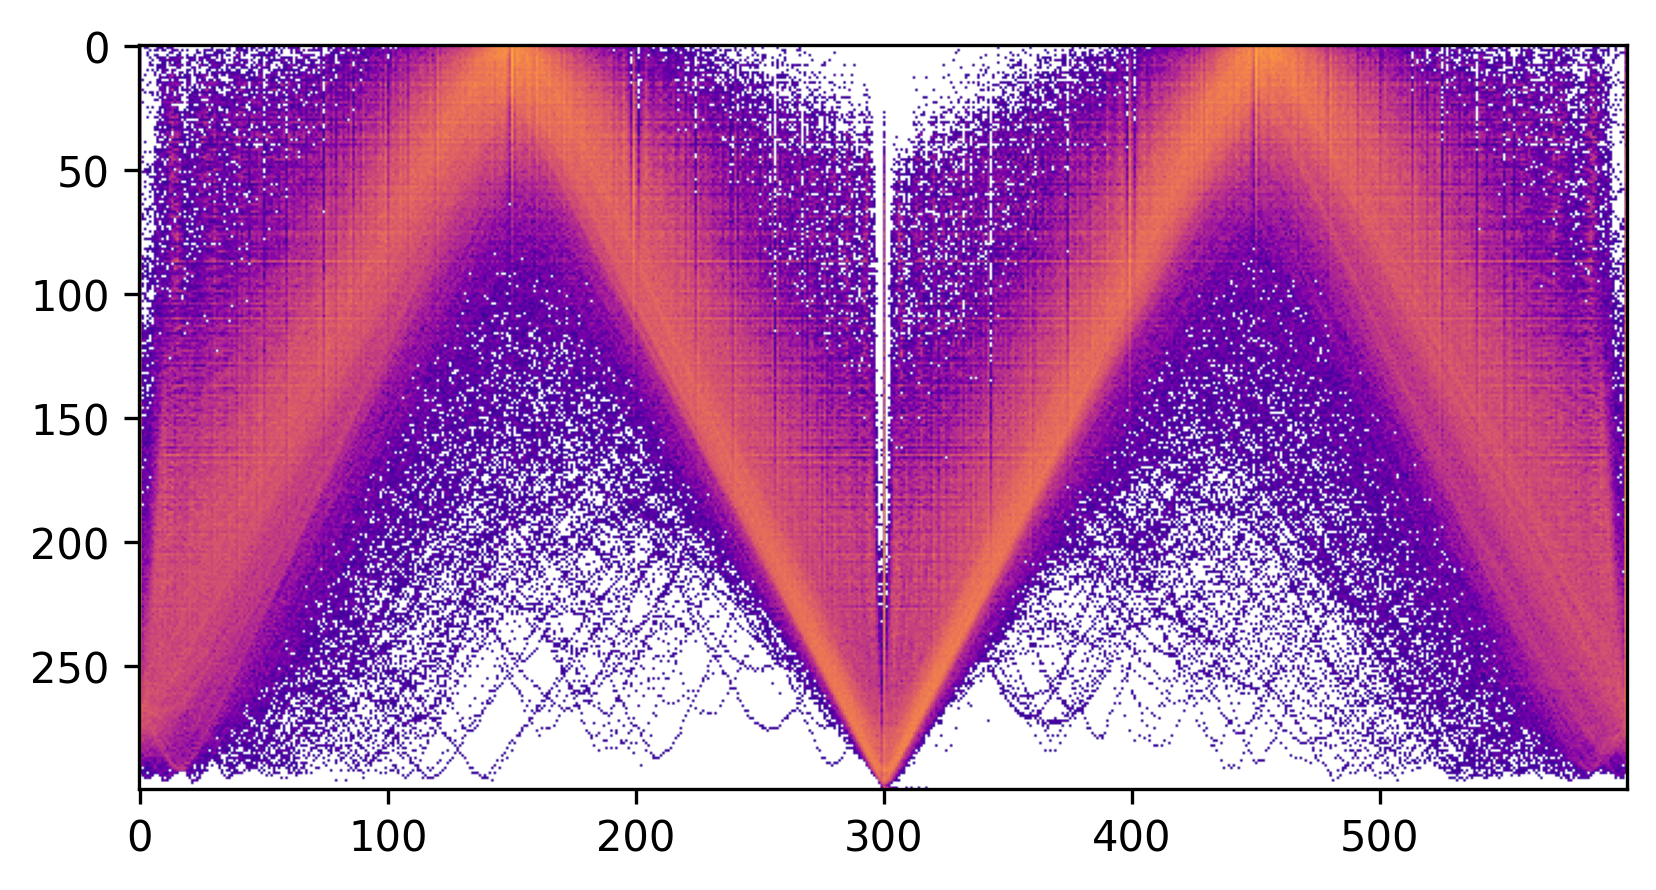

2021-11-10 00:24:13,169 [WARNING] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2021-11-10 00:24:13,169 [WARNING] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


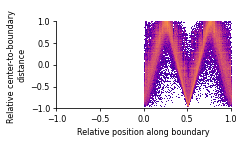

In [27]:

t = 'all'
if t=='bad':
    group = bad_cell
    suffix = '_bad_cell'
elif t=='good':
    group = good_cell
    suffix = '_good_cell'
elif t=='all':
    group = all_cells
    suffix = '_all_cells'   
nr = [np.abs(group[0][i][2]) for i in range(len(group[0]))]
th = [np.abs(group[0][i][3]) for i in range(len(group[0]))]

X = []
Y = []
for k in range(len(nr)):
    y = nr[k]/np.max(nr[k])
    imin = np.argmin(y)
    x = np.linspace(-1,1,len(nr[k]))#-imin/len(y)
#     sind = np.argsort(y) # scatter plot sorted by y or x but re-sorting both y or x gives same plot, just appear in different order 
    # really what I want is to make sure that the x coordinate is unbiased... that is, show how distances change sa you go further away from the projected point
    #right now it is basically that, but each is shifted 
    
    
    #INDEXING is critical... right now assumes that the x a xis spreads out cells uniformly with distance 
    
    # plotting y vs theta (y=r) recapitulates cell shapes, sort of
#     theta = np.concatenate(th[k])
#     sind = np.argsort(theta)
#     thmin = theta[imin]
#     theta = theta - thmin
#     theta = theta[sind]

#     x = x[sind]
#     y = y[sind]
    Y.append(y)
#     X.append(theta)
    X.append(x)
    
    
    
X = np.array([item for sublist in X for item in sublist])
Y = np.array([item for sublist in Y for item in sublist])


# Construct 2D histogram from data using the 'plasma' colormap
from scipy.ndimage.filters import gaussian_filter
heatmap, xedges, yedges = np.histogram2d(Y, X, bins=(300,600))
# heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap = mpl.cm.get_cmap('plasma')
v = omnipose.utils.rescale(np.log(np.flipud(heatmap)+1))
pic = cmap(v)
pic[:,:,-1] = v>0

#save just the image
basedir = '/home/kcutler/DataDrive/Omnipose_paper/Figure 3/'
name = '_projected_normalized_distance'+suffix
skimage.io.imsave(basedir +name+'_just_2DH_hist' + '.png',((pic)*255).astype(np.uint8))
plt.imshow(pic)
plt.show()
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline

A = .75
labelsize = 8
px = A/plt.rcParams['figure.dpi']  # pixel in inches
lx = pic.shape[1]
ly = pic.shape[0]
fig,ax = plt.subplots(figsize=(ly*px,lx*px))


plt.imshow(pic, extent=extent, origin='upper',interpolation='nearest')
plt.xlim(-1,1)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)

ax.set_ylabel('Relative center-to-boundary \ndistance',size=labelsize)
ax.set_xlabel('Relative position along boundary',size=labelsize)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)
ax.set_aspect(1/2)
plt.show()

fig.savefig(basedir + name  + '.svg',bbox_inches=0,transparent=True,pad_inches=0)
fig.savefig(basedir + name  + '.pdf',bbox_inches='tight',transparent=True,pad_inches=0)

In [13]:

_names = [group[0][i][-2] for i in range(len(group[0]))]
# print(_names)
# name = 'Hpylori'
name = 'Serratia'
name = 'wiggins'
# name = 'bthai'
# name = '5I'
# indices = [i for i, s in enumerate(img_names[0]) if name in getname(s,suffix='.tif')]
indices = [i for i, s in enumerate(_names) if name in s]
indices = range(len(_names))
# np.unique(_names)
# [_names[i] for i in indices]

In [35]:
from matplotlib import rc
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline


from scipy.signal import argrelextrema
from math import gcd
from scipy.ndimage import binary_erosion

PSVB_ensemble_a_5
index 8259 (55, 107)


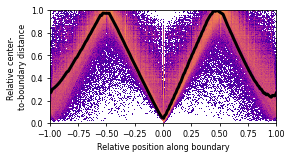

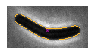

<Figure size 432x288 with 0 Axes>

hey
Az_branch_ec_11
index 3676 (119, 62)


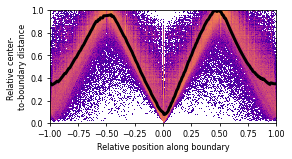

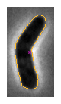

<Figure size 432x288 with 0 Axes>

hey
PSVB_ensemble_a_1
index 7665 (39, 108)


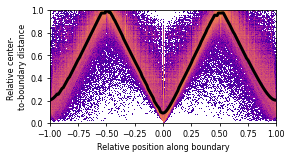

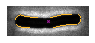

<Figure size 432x288 with 0 Axes>

hey
Az_branch_ec_13
index 3732 (170, 80)


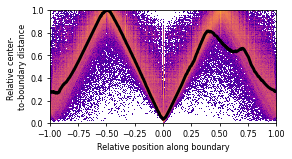

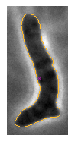

<Figure size 432x288 with 0 Axes>

hey
wiggins_ensemble_16
index 23295 (37, 61)


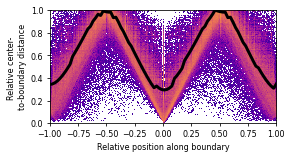

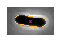

<Figure size 432x288 with 0 Axes>

hey


In [15]:
# group = all_cells
show_im = 1
plot_closest = 0
save = 1 ####################toggle
group = all_cells
# for ind in range(len(group[0])):
np.random.seed(42)
bg = 0.5
# for ind in np.random.choice(indices,12):
# for ind in indices:
# for ind in [12304, 11870 ,12193, 12228, 12284, 12313]: #Hpylori
# for ind in [23295]: # e coli wt
for ind in [8259,3676,7665,3732,23295]: #all
# for ind in [11870]:
# for ind in [34,96,116]:
# for ind in [5]:
    r = group[0][ind][2]
    theta = np.concatenate(group[0][ind][3])
#     inds = np.argsort(theta)
#     r = r[inds]

    # [mask,phase,dist_to_bound,angles,ymed,xmed,ymed_,xmed_,y_,x_,name,labels
#     if nr<.2:
    argmins = argrelextrema(r, np.less,mode='wrap',order=3)[0]
#     print('number of minma',len(argmins),argmins)
#     if len(argmins)>4:
#     if 1:
    mask = np.array(group[0][ind][0]).astype(int)
    nr = np.min(np.abs(r))/utils.diameters(mask,omni=True)[0]
    lbl = np.array(group[0][ind][-1]).copy()
    if len(np.unique(lbl))<3 and np.count_nonzero(mask)>200:# and nr<.2:
        print(_names[ind])
        p = utils.rescale(group[0][ind][1])
        phase = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(mask==0)])))

        regions = skimage.measure.regionprops(mask)
        coords = group[0][ind][4:-2]
        # print('dist to boundary',bad_cell[0][ind][2])
        print('index',ind,mask.shape)

        A = .5
        labelsize = 8
        dpi = 72
        plt.rcParams['figure.dpi'] = dpi
        px = A/dpi  # pixel in inches
        ly,lx = pic.shape[:2]
        fig,ax = plt.subplots(figsize=(A*lx/dpi,A*ly/dpi),dpi=dpi)

        # plt.xlim(-1,1)
        ax = plt.gca()
        ax.set_aspect('equal')
        ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
        ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)

        ax.set_ylabel('Relative center- \nto-boundary distance',size=labelsize)
        ax.set_xlabel('Relative position along boundary',size=labelsize)
        
        
        h,w= pic.shape[:2]
        x = np.linspace(-1,1,len(r))#-np.argmin(r)/len(r)
        y = r/np.max(r)


        ax.plot(x,y,'k-',linewidth=3)
        
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1])
        plt.imshow(pic, extent=[-1, 1.0, 0, 1.0], origin='upper',interpolation='none')


        plt.show()
    
    
        name = group[0][ind][-2]+'_'+str(ind)
        if save:
            fig.savefig(basedir + name  + '.svg',bbox_inches=0,transparent=True,pad_inches=0)
            fig.savefig(basedir + name  + '.eps',bbox_inches='tight')
            fig.savefig(basedir + name  + '.pdf',bbox_inches='tight',transparent=True,pad_inches=0)
        
        if show_im:
            ly,lx = mask.shape
            fig,ax = plt.subplots(figsize=(lx/dpi,ly/dpi), dpi=dpi)
            labels,dists,heat,flows = dynamics.masks_to_flows(mask,use_gpu=True,omni=False)
            dP = np.stack([flows[0],flows[1]])
            ol = plot.outline_view(phase,mask,color=cmap(.85)[:3])
            cmap = mpl.cm.get_cmap('plasma')
            pic2 = cmap(utils.rescale(heat))
            pic2[:,:,-1] = mask>0

            pic3 = plot.dx_to_circ(dP,transparency=True)

            div = utils.rescale(divergence(dP))
            pic4 = cmap(div)
            pic4[:,:,-1] = mask>0
            if save:
                skimage.io.imsave(basedir + name +'_8bit_heat' + '.png',((pic2)*255).astype(np.uint8))
                skimage.io.imsave(basedir + name+'_GT_flow'+'.png',(pic3*(2**8-1)).astype(np.uint8))
                skimage.io.imsave(basedir + name+'_GT_divergence'+'.png',(pic4*(2**8-1)).astype(np.uint8))

            
            ax.imshow(ol,interpolation='none')
            xmed,ymed = coords[1],coords[0]
            x_,y_ = coords[-1],coords[-2]
            
            if plot_closest:
                ax.plot(x_[argmins],y_[argmins],'.',color='mediumturquoise',markersize=5, markeredgewidth=0) #minima
            ax.plot(xmed,ymed,'x',color=cmap(.35),markersize=2.5,mew=1) # median
#             ax.set_xlim([0,lx])
#             ax.set_ylim([ly,0])
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            plt.axis('off')
            plt.show()
            if save:
                skimage.io.imsave(basedir + name+'_outlines'+'.png',(ol*(2**8-1)).astype(np.uint8))
                fig.savefig(basedir + name  + '_outline_median_px.pdf',bbox_inches='tight',
                            transparent=True,pad_inches=0)
                fig.savefig(basedir + name  + '_outline_median_px.eps',format='eps',bbox_inches='tight',
                            transparent=True,pad_inches=0)


        
#         ax =axs[2]
#         theta = group[0][ind][3]
#         ax.plot(theta,'r.',markersize=1)
#         ax.set_ylabel('angle',size=labelsize)
#         ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#         ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)

#         ax = axs[3]
#         ax.scatter(r,theta,c='b',s=1)
#         ax.set_ylabel('angle vs distance',size=labelsize)
#         # ax = fig.add_subplot(projection='polar')
#         # ax.scatter(theta, r, c=theta, s=1, cmap='hsv', alpha=0.75)

#         # selection = r<np.percentile(r,1)
#         # select_theta = theta[selection]
#         # print(np.min(r),np.ptp(select_theta))
#         ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#         ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)


        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 1)
        plt.show()
        print('hey')
#[mask,phase,dist_toadound,angles,diam,ymed,xmed,ymed_,xmed_]

In [16]:
# import seaborn as sns
# sns.palplot(cmap(.8))

# cmap
# all_cells[0][ind][4:-2]
basedir


'/home/kcutler/DataDrive/skelpose_paper/Figure 3/'

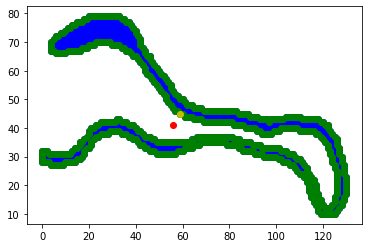

In [375]:
import cv2

y,x = np.nonzero(mask)
contours = cv2.findContours((mask>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
x_,y_ = np.concatenate(contours[-2], axis=0).squeeze().T 

# original boundary projection
ymed = np.median(y)
xmed = np.median(x)
imin = np.argmin((x-xmed)**2 + (y-ymed)**2) 
xmed_ = x[imin]
ymed_ = y[imin]

dist_to_bound = np.sqrt((x_-xmed)**2 + (y_-ymed)**2) #absolute distance to boundary
imin = np.argmin(dist_to_bound)
min_dist_to_bound =dist_to_bound[imin]
l = len(dist_to_bound)
diff_ind = int(l/2-imin) % l
dist_to_bound = np.roll(dist_to_bound,diff_ind)
x_ = np.roll(x_,diff_ind)
y_ = np.roll(y_,diff_ind)

angles = np.array([np.arctan2([y_[i]-ymed],[x_[i]-xmed]) for i in range(len(y_))])
plt.scatter(x,y,color = 'b')
plt.scatter(xmed,ymed,color = 'r')
plt.scatter(x_,y_,color = 'g')
i = int(l/2)
plt.scatter(x_[i],y_[i],color='y')

In [369]:
np.argmin(dist_to_bound),len(dist_to_bound),i, diff_ind

(410, 568, 284, -63)

In [625]:
y, x = np.nonzero(mask) 
dist = edt.edt(mask)
bd = dist==1
y_, x_ = np.nonzero(bd) 

# original boundary projection
ymed = np.median(y)
xmed = np.median(x)
imin = np.argmin((x-xmed)**2 + (y-ymed)**2) 
xmed_ = x[imin]
ymed_ = y[imin]

dist_to_bound = np.min(np.sqrt((x_-xmed)**2 + (y_-ymed)**2)) #absolute distance to boundary

print(ymed,xmed,ymed_,xmed_,dist_to_bound )

21.0 16.5 21 16 3.640054944640259


In [452]:
coords

[31.0, 141.5, 18, 139, 'caulo_4']

In [110]:
np.median(y)

50.0

In [152]:
np.median([1,1,2,2])

1.5

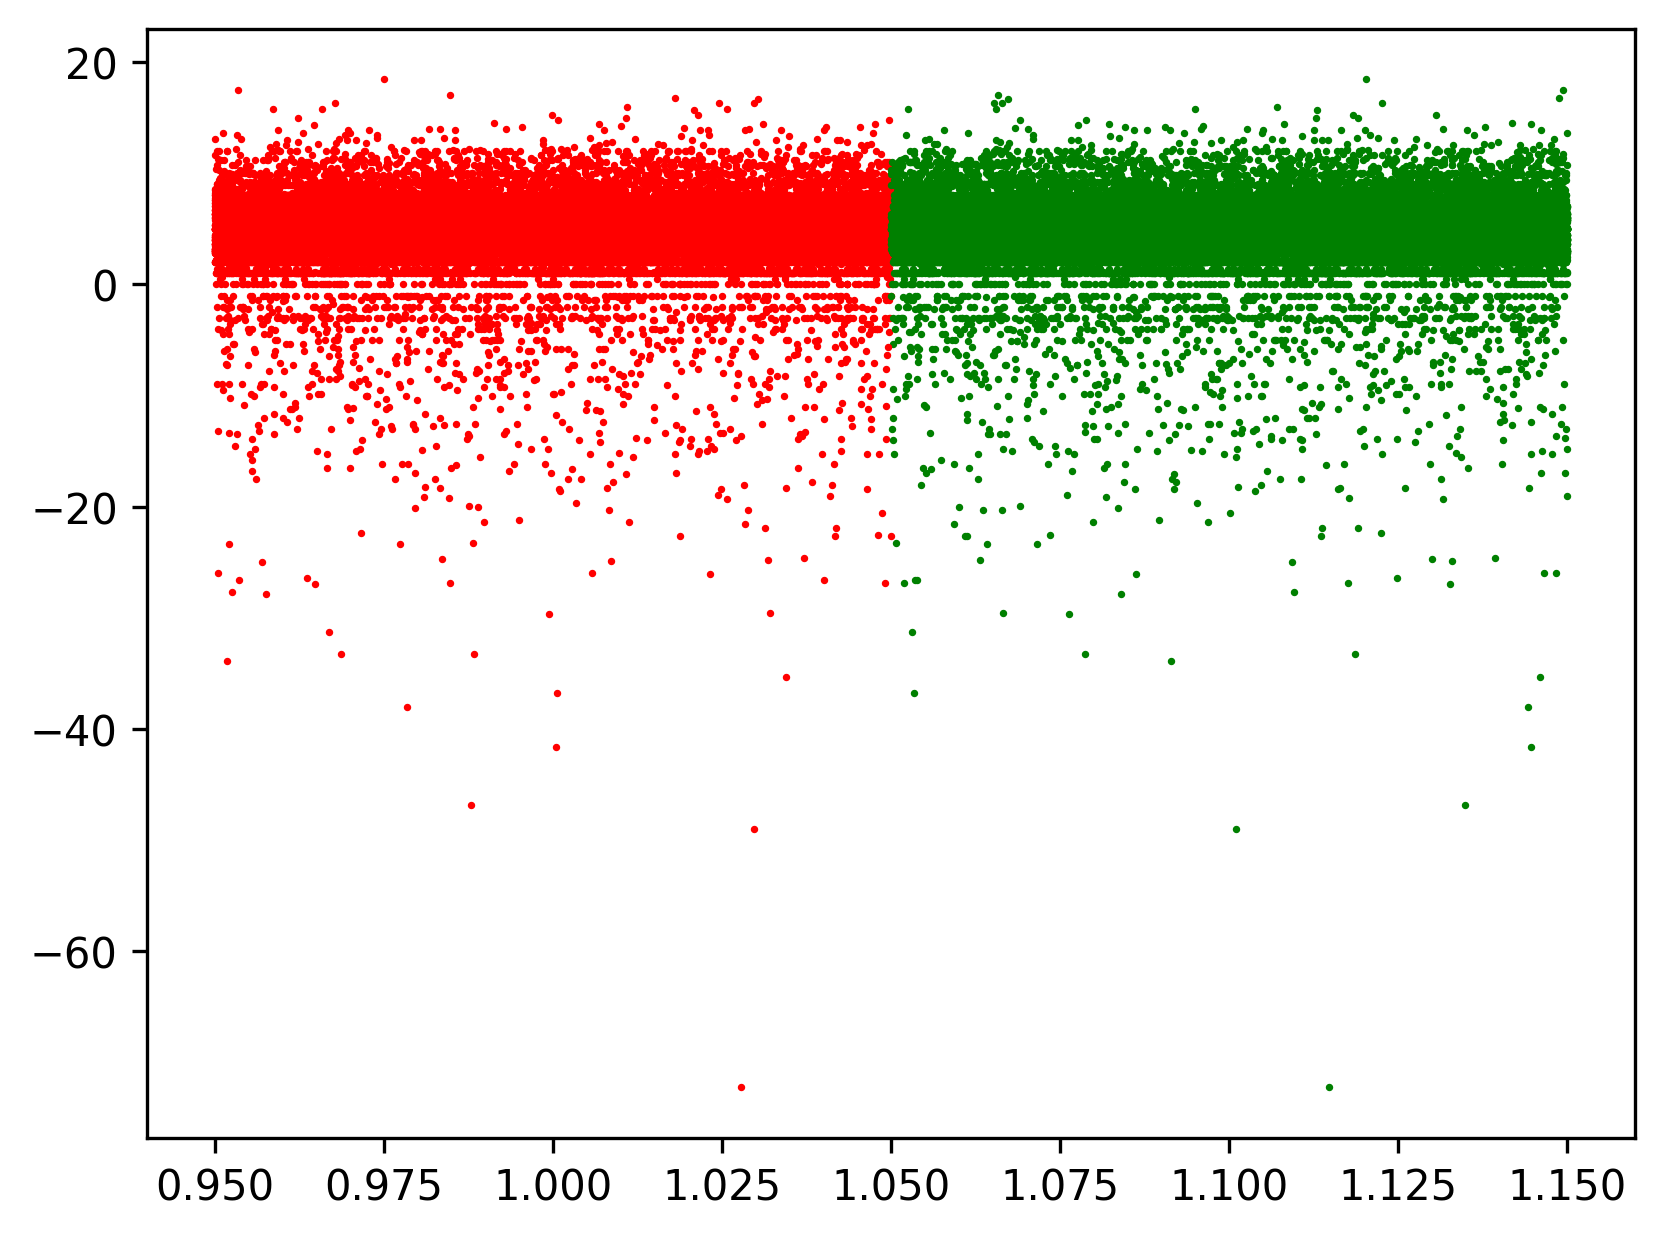

In [255]:
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
fig,ax = plt.subplots()
box = 0
w0 = .1
dotcolors = ['r','g']
for k in range(2):
    w = w0
    x = [1-w0/2,1+w0/2]
    y = np.array(d2b[k])
    height = [np.mean(yi) for yi in y]
#     print(height,len(y))
    if box:
        ax.bar(x,
               height=[np.mean(yi) for yi in y[j]],
        #        yerr=[np.std(yi) for yi in y],    # error bars
        #        capsize=12, # error bar cap width in points
               width=w,    # bar width
    #            tick_label=names,
               color=(0,0,0,0),  # face color transparent
               edgecolor=colors,
               label=None
               #        ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
               )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        #  np.random.random(y[j][i].size) * w - w / 2
#         ax.scatter(x[i]+np.zeros((y[j][i].size)), y[j][i], color=dotcolors[i]**0.5, s=sz*72/10,marker=MarkerStyle('.', fillstyle='full'),edgecolors=None,label= (cats[i] if j==0 else None))
#         ax.scatter(x[i] + np.linspace(0,1,y[j][i].size) * w - w / 2, y[j][i], color=colors[i]**0.5, s=sz*72/20,marker=MarkerStyle('.', fillstyle='full'))
        ax.scatter(x[i] + (np.random.random(y.size) * w), y, color=dotcolors[i], s=sz*72/60,marker=MarkerStyle('.', fillstyle='full'),edgecolors=None)
plt.show()

In [177]:
np.random.random(y.size)

array([0.41728009, 0.16400535, 0.22969738, ..., 0.59031438, 0.16613573,
       0.06616369])

In [182]:
np.min(y)

-0.5

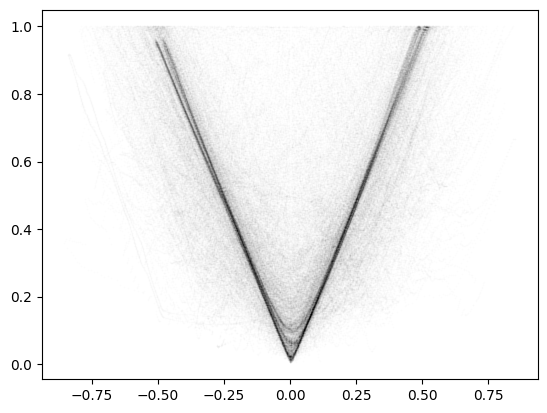

In [77]:
fig = plt.figure()
for k in range(len(X)):
    plt.plot(X[k],Y[k],'k.',alpha=.01,markersize=1)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# from matplotlib.ticker import FormatStrFormatter
# from scipy.stats import gaussian_kde

# color = [1,0,0,.5]
# axcol = 'k'

# cm = plt.cm.get_cmap('plasma')

# x = X.copy()
# y = Y.copy()
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]
# ax.scatter(x, y, c=np.log(z), s=1,cmap=cm)
    

In [30]:
masks = [all_cells[0][i][0] for i in range(len(all_cells[0]))]
imgs = [omnipose.utils.rescale(all_cells[0][i][1]) for i in range(len(all_cells[0]))]
len(masks)

27518

In [31]:
areas = np.array([np.sum(m) for m in masks])
diams = np.array([utils.diameters(m,omni=True)[0] for m in masks])

In [32]:
inds = np.argwhere(diams>35).flatten()
inds.size,np.median(diams)

(122, 17.106467485427856)

# Figure 4

index 4243


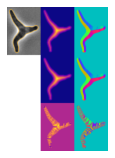

index 19151


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_4243_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


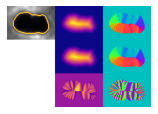

index 2889


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_19151_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


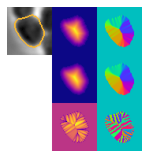

index 4214


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_2889_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


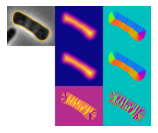

index 4023


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_4214_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


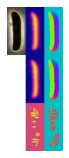

index 4030


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_4023_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


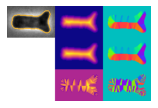

index 3955


/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_4030_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


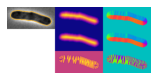

/tmp/ipykernel_17261/77937738.py:80: UserWarning: /home/kcutler/DataDrive/Omnipose_paper/Figure 4/cell_3955_mask.png is a low contrast image
  skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))


In [41]:
cmap = mpl.cm.get_cmap('plasma')
bg = 0.5
# for i in inds:
from cellpose import transforms
from scipy.ndimage.morphology import binary_dilation

def derivative(T,masks):
    Ly,Lx = T.shape
    mu = np.zeros((2,Ly,Lx))
    pad = 1
    slices = scipy.ndimage.find_objects(masks) 
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            mask = np.pad((masks[sr, sc] == i+1),pad)
            ly, lx = sr.stop - sr.start + 2*pad, sc.stop - sc.start + 2*pad
            y, x = np.nonzero(mask) 
            ly = np.int32(ly)
            lx = np.int32(lx)
            y = y.astype(np.int32)  #no need to shift, as array already padded
            x = x.astype(np.int32)    

            T_ = np.zeros((ly+2*pad)*(lx+2*pad), np.float64)
            T_[y*lx+x] = T[sr.start+y-pad, sc.start+x-pad]
            dy = (T_[(y+1)*lx + x] - T_[(y-1)*lx + x]) / 2
            dx = (T_[y*lx + x+1] - T_[y*lx + x-1]) / 2
            mu[:, sr.start+y-pad, sc.start+x-pad] = np.stack((dy,dx))
    return mu

basedir = '/home/kcutler/DataDrive/Omnipose_paper/Figure 4/'
# for i in [inds[-13]]:
# for i in inds:
for i in [4243,19151,2889,4214,4023,4030,3955]:
    border_mask = np.zeros(masks[i].shape, dtype=bool)
    border_mask = binary_dilation(border_mask, border_value=1, iterations=5)
    overlap = np.count_nonzero(np.logical_and(masks[i], border_mask))
    if overlap==0:
        p = imgs[i]
        mask = masks[i]
        phase = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(mask==0)])))
        
        print('index',i)
        fig = plt.figure(figsize=(2,2))
        dist = edt.edt(masks[i])
        smooth_dist = omnipose.core.smooth_distance(masks[i],dist)
        mu = derivative(dist,masks[i])
        mu = transforms.normalize_field(mu)
        mu2 = derivative(smooth_dist,masks[i])
        mu2 = transforms.normalize_field(mu2)
        outline = plot.outline_view(phase,mask,color=cmap(.85)[:3],mode='thick')
        flow1 = plot.dx_to_circ(mu,transparency=True)
        flow2 = plot.dx_to_circ(mu2,transparency=True)
        colordist1 = cmap(omnipose.utils.rescale(dist))
        colordist1[:,:,-1] = masks[i]>0
        colordist2 = cmap(omnipose.utils.rescale(smooth_dist))
        colordist2[:,:,-1] = masks[i]>0
        diff1 = cmap(omnipose.utils.rescale(smooth_dist-dist))
        diff1[:,:,-1] = masks[i]>0
        diff2 = plot.dx_to_circ(mu2-mu,transparency=True)

        plt.imshow(np.vstack((np.hstack((outline, colordist1[:,:,:3], flow1[:,:,:3])),
                              np.hstack((np.ones_like(outline), colordist2[:,:,:3],flow2[:,:,:3])),
                              np.hstack((np.ones_like(outline), diff1[:,:,:3], diff2[:,:,:3])))
                            ))
        plt.axis('off')
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
        plt.show()
        
        name = 'cell_'+str(i)
        savedir = os.path.join(basedir,name)
        skimage.io.imsave(savedir + '_outlines'+'.png',(outline*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_FMM'+'.png',(colordist1*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_smoothdist'+'.png',(colordist2*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_FMM_flow'+'.png',(flow1*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_smoothdist_flow'+'.png',(flow2*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_dist_diff'+'.png',(diff1*(2**8-1)).astype(np.uint8))
        skimage.io.imsave(savedir + '_flow_diff'+'.png',(diff2*(2**8-1)).astype(np.uint8))
        
        skimage.io.imsave(savedir + '_mask'+'.png',mask.astype(np.uint8))
        skimage.io.imsave(savedir + '_phase'+'.png',(phase*255).astype(np.uint8))
        
        skimage.io.imsave(savedir + '_boundary'+'.png',((dist==1)*(2**8-1)).astype(np.uint8))

        
        

In [586]:
'g'+str(i)

'g2541'

'/home/kcutler/DataDrive/skelpose_paper/Figure 3/'